In [1]:
library(tidyverse)
library(data.table)
library(latex2exp)
library(googlesheets)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [20]:
# gs_auth(token = "~/.googlesheets_token.rds")
# file <- 'https://docs.google.com/spreadsheets/d/1gwzS0SVZBSKkkHgsoqB5vHo5JpUeYYz8PK2RWrHEq3A'
# names_df <- file %>% gs_url() %>% gs_read(ws = 'GBE_names')


In [21]:
names_df <- data.table(
    GBE_ID = c('INI5254', 'INI5255', 'INI5262', 'INI5263'),
    GBE_NAME = c(
        'Intra-ocular_pressure,_corneal-compensated_(right)',
        'Intra-ocular_pressure,_Goldmann-correlated_(right)',
        'Intra-ocular_pressure,_corneal-compensated_(left)',
        'Intra-ocular_pressure,_Goldmann-correlated_(left)'
    ),
    GBE_short_name = c(
        'IOP, corneal-compensated (R)',
        'IOP, Goldmann-correlated (R)',
        'IOP, corneal-compensated (L)',
        'IOP, Goldmann-correlated (L)'
    )
)

In [7]:
log_dir='data'
dataset='ANGPTL7'
ldsc_dir='/oak/stanford/groups/mrivas/dev-ukbb-tools/ldsc'


In [10]:
df <- fread(
    cmd=paste0(
        'find ', log_dir, 
        ' -maxdepth 1 -type f -name "*.log"', 
        " | while read f ; do cat $f | tail -n4 | head -n1 ; done",    
        ' | sed -e "s%', file.path(ldsc_dir, 'munged', dataset), '/ukb24983_v2_hg19.%%g"', 
        ' | sed -e "s%.genotyped.sumstats.gz%%g"',
        ' | sort -k1V'
    ), data.table=F, head=F, 
)

colnames(df) <- c(
    'p1', 'p2', 'rg', 'se', 'z', 'p', 
    'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se'
)

In [25]:
merged_df <- df %>% 
left_join(
    names_df %>% select(GBE_ID, GBE_NAME, GBE_short_name) %>% rename(p2 = GBE_ID),
    by='p2'
)


In [26]:
merged_df

p1,p2,rg,se,z,p,h2_obs,h2_obs_se,h2_int,h2_int_se,gcov_int,gcov_int_se,GBE_NAME,GBE_short_name
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
INI5255,INI5254,0.7920,0.0159,49.9037,0.0000e+00,0.1490,0.0106,1.0162,0.0075,0.8266,0.0070,"Intra-ocular_pressure,_corneal-compensated_(right)","IOP, corneal-compensated (R)"
INI5255,INI5262,0.8297,0.0220,37.7411,1.0532e-311,0.1576,0.0105,1.0083,0.0072,0.5488,0.0062,"Intra-ocular_pressure,_corneal-compensated_(left)","IOP, corneal-compensated (L)"
INI5255,INI5263,1.0175,0.0096,105.7755,0.0000e+00,0.2253,0.0133,1.0090,0.0082,0.7368,0.0074,"Intra-ocular_pressure,_Goldmann-correlated_(left)","IOP, Goldmann-correlated (L)"


In [27]:
merged_df %>% fwrite(paste0(dataset, '.tsv'), row.names = F, sep='\t')


In [54]:
plot_df <- merged_df %>% 
filter(p <= (0.05 / merged_df %>% dim() %>% first())) %>%
select(p2, rg, se, p, GBE_NAME, GBE_short_name) %>% 
mutate(
    xlabel = paste0(GBE_short_name, ' (', p2, ')'),
    ymin = rg - 1.96 * se,
    ymax = rg + 1.96 * se
)


In [55]:
plot_df

p2,rg,se,p,GBE_NAME,GBE_short_name,xlabel,ymin,ymax
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
INI5254,0.7920,0.0159,0.0000e+00,"Intra-ocular_pressure,_corneal-compensated_(right)","IOP, corneal-compensated (R)","IOP, corneal-compensated (R) (INI5254)",0.760836,0.823164
INI5262,0.8297,0.0220,1.0532e-311,"Intra-ocular_pressure,_corneal-compensated_(left)","IOP, corneal-compensated (L)","IOP, corneal-compensated (L) (INI5262)",0.786580,0.872820
INI5263,1.0175,0.0096,0.0000e+00,"Intra-ocular_pressure,_Goldmann-correlated_(left)","IOP, Goldmann-correlated (L)","IOP, Goldmann-correlated (L) (INI5263)",0.998684,1.036316


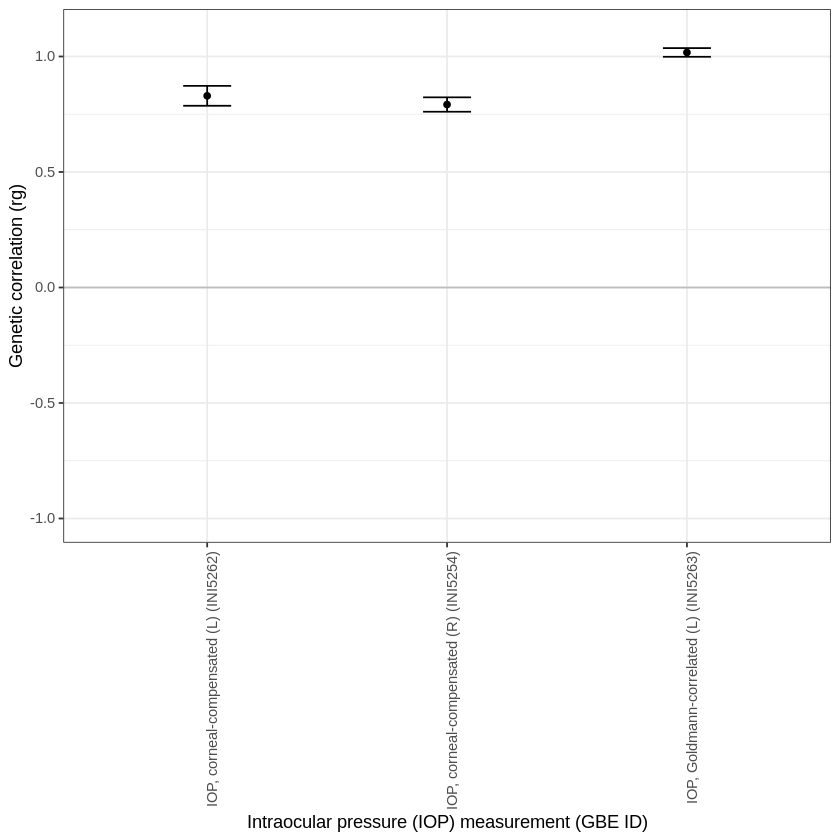

In [53]:
p <- plot_df %>% 
ggplot(aes(x = xlabel, y = rg)) + 
geom_point() + 
geom_errorbar(aes(ymin = ymin, ymax = ymax), width = 0.2) + 
geom_hline(yintercept = 0, color='gray')+
ylim(-1, 1.1)+
theme_bw()+
theme(
    axis.text.x = element_text(angle = 90, hjust = 1),
    legend.position=c(0.02,0.02),
    legend.justification=c(0,0)
) + 
labs(
    x = 'Intraocular pressure (IOP) measurement (GBE ID)',
    y = 'Genetic correlation (rg)'
)

p

In [56]:
ggsave(paste0(dataset, '.pdf'), p)


Saving 6.67 x 6.67 in image


In [57]:
ggsave(paste0(dataset, '.png'), p)


Saving 6.67 x 6.67 in image
